### Notebook principal pour le test du système

In [ ]:
import pandas as pd
from PIL import Image
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from pipeline_data_integration.data_integration import data_integration_pipeline
from pipeline_recommendation.classical_recommendation import try_from_pickle, tfidf, embeded_similarity

#### Pipeline d'intégration des données

Cette pipeline nous permet de charger les données et de les augmenter avec un LLM multimodal.
Elle opère différents traitement sur les données afin qu'elles soient utilisables par les systèmes de recommandations.
En production cette pipeline ne tournerait qu'une seule fois au déploiement de l'application puis lors de mises 
à jour ou d'ajout d'items dans la base de données.  
⚠️ Pour des raisons de démo nous allons charger artificiellement le resultat de cette pipeline dans la cellule suivante  
⚠️ Ne pas exécuter cette cellule car cela nous as pris 10h à exécuter sur une GTX3060

In [ ]:
# ⚠️ Ne pas exécuter cette cellule ⚠️
data_integration_pipeline()

In [3]:
# Pour la démo nous chargeons les dataframes depuis les checkpoints de l'étape précédente (pour une raison de temps)
df_outfits = pd.read_pickle("checkpoints/outfits_first_augmentation.pkl")
df_clothes = pd.read_pickle("checkpoints/clothes_second_augmentation.pkl")

Percentage of augmented rows : 100.0%
Exemple of row :
+------+------------+-----------------+--------------+---------------------------------+---------------------------------+-------------------------------------------------------+--------+
|      |   image_id | image_path      | label_type   | label_path                      | raw_label_path                  | caption                                               | type   |
|------+------------+-----------------+--------------+---------------------------------+---------------------------------+-------------------------------------------------------+--------|
| 1004 |       1005 | images/1005.jpg | image-level  | image_level_labels_txt/1005.txt | image_level_labels_mat/1005.mat | Walking the runway of life with confidence and style! | Casual |
+------+------------+-----------------+--------------+---------------------------------+---------------------------------+-------------------------------------------------------+--------+


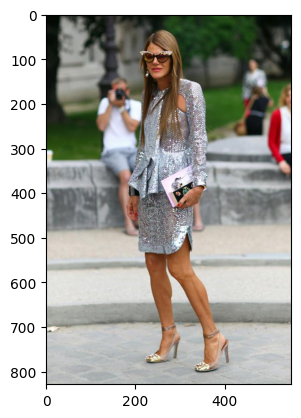

In [30]:
# Informations sur le dataframe de tenues
print(f"Percentage of augmented rows : {((len(df_outfits)-df_outfits.caption.isna().sum())/len(df_outfits))*100}%")
print(f"Exemple of row :")
print(tabulate(df_outfits.iloc[[0]], headers='keys', tablefmt='psql'))

img = np.asarray(Image.open('data/clothing-coparsing-dataset/images/1005.jpg'))
plt.imshow(img)

In [35]:
# Informations sur le dataframe d'habit
print(f"Percentage of augmented rows : {((len(df_clothes)-df_clothes.caption.isna().sum())/len(df_clothes))*100}%")
print(f"Exemple of row :")
print(tabulate(df_clothes.iloc[[25]], headers='keys', tablefmt='psql'))

Percentage of augmented rows : 34.06884377758164%
Exemple of row :
+----+--------------+-------------+-----------------+----------------------------------------------------------+--------------+-------------+---------+
|    | class_name   |   outfit_id | image_path      | caption                                                  | baseColour   | category    | usage   |
|----+--------------+-------------+-----------------+----------------------------------------------------------+--------------+-------------+---------|
| 25 | bag          |        1007 | images/1008.jpg | Chic and stylish ensemble, perfect for a casual day out. | Multi        | Apparel Set | Casual  |
+----+--------------+-------------+-----------------+----------------------------------------------------------+--------------+-------------+---------+


#### Algorithme de recommandation classique

Ici, nous vous présentons notre pipeline de recommandation classique, pour le fil d'actualité. Celle-ci est disponible dans la fonction `run_recommendation_pipeline`, mais une méthode `try_from_pickle` a été créée afin de faciliter son exécution sur un utilisateur aléatoire. Elle retourne une liste de similarité cosine, pour tout les éléments du tableau d'habits.
Deux fonctions, `tfidf()` et `embeded_similarity(model)`, ont été créées, permettant ainsi d'exécuter cette pipeline en modifiant à notre guise l'algorithme à son coeur.

In [9]:
# Avec le tfidf
try_from_pickle("checkpoints/clothes_second_augmentation.pkl", tfidf, one_hot=True)

TypeError: try_from_pickle() got an unexpected keyword argument 'one_hot'

In [10]:
# Avec l'embedding via all-minilm
try_from_pickle("checkpoints/clothes_second_augmentation.pkl", embeded_similarity, {"model": "all-minilm"})

Embedding with all-minilm: 100%|██████████| 2702/2702 [01:59<00:00, 22.63it/s]


[[np.float64(1.972835138164264e-05),
  np.float64(1.2598098616534159e-05),
  np.float64(1.972835138164264e-05),
  np.float64(1.4943024802205329e-05),
  np.float64(1.6805458742386037e-06),
  np.float64(4.058274747809065e-06),
  np.float64(1.6805458742386037e-06),
  np.float64(4.739250857088706e-06),
  np.float64(4.739250857088706e-06),
  np.float64(1.6805458742386037e-06),
  np.float64(4.058274747809065e-06),
  np.float64(1.0085491092159948e-05),
  np.float64(1.4943024802205329e-05),
  np.float64(1.4943024802205329e-05),
  np.float64(1.2598098616534159e-05),
  np.float64(8.586177407177153e-06),
  np.float64(4.058274747809065e-06),
  np.float64(4.058274747809065e-06),
  np.float64(7.501558765055094e-06),
  np.float64(4.058274747809065e-06),
  np.float64(7.3810294158871415e-06),
  np.float64(4.739250857088706e-06),
  np.float64(1.4018172155960684e-05),
  np.float64(3.168026973721094e-05),
  np.float64(3.168026973721094e-05),
  np.float64(4.739250857088706e-06),
  np.float64(1.939919297755

In [13]:
# Avec l'embedding via nomic-embed-text
try_from_pickle("checkpoints/clothes_second_augmentation.pkl", embeded_similarity, {"model": "nomic-embed-text"})

Embedding with nomic-embed-text:   0%|          | 2/2702 [00:01<40:00,  1.12it/s]


KeyboardInterrupt: 

In [12]:
# Avec l'embedding via mxbai-embed-large
try_from_pickle("checkpoints/clothes_second_augmentation.pkl", embeded_similarity, {"model": "mxbai-embed-large"})

Embedding with mxbai-embed-large:   0%|          | 1/2702 [00:04<3:07:58,  4.18s/it]


KeyboardInterrupt: 